# Miniproyecto #3: Máquinas de soporte vectorial (SVM)


**Autores:**
*   Jorge Sebastián Arroyo Estrada CC. 1193482707
*   César Augusto Montoya Ocampo CC. 1036681523

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

---

## Librerías

Importa diversas bibliotecas para el análisis y procesamiento de datos, así como para la implementación y evaluación de modelos de aprendizaje automático. Se utilizan bibliotecas estándar como `json`, `pickle` y `datetime` para manejo de archivos y tiempos. `matplotlib`, `numpy` y `pandas` se emplean para visualización y manipulación de datos. Las métricas y herramientas de `sklearn` como `accuracy_score`, `f1_score`, y `confusion_matrix` se usan para evaluar el rendimiento de modelos, mientras que `GridSearchCV` y `train_test_split` facilitan la optimización y la partición de los datos. Además, se importa un clasificador de máquinas de soporte vectorial (`SVC`) y un preprocesador (`StandardScaler`).

In [8]:
import json
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from classification import main_pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.svm import SVC

## Globales

Definir rutas para archivos de bases de datos, configurando parámetros globales para un modelo de ML. Establece la ruta base de las características (`DB_BASE_PATH`) y genera listas de nombres y rutas de archivos para cuatro bases de datos con resoluciones de 64x64 y 128x128, diferenciando entre características y PCA. También define la ruta para un archivo de etiquetas (`LABELS_PATH`) y crea un directorio para almacenar los resultados del modelo (`RESULTS_FOLDER`). Se configuran parámetros globales como el estado aleatorio (`RANDOM_STATE`), la validación cruzada (`K`), el estimador con el parámetro de búsqueda de la cuadrícula (`PARAM_GRID`), y las métricas de evaluación como `precision`, `accuracy`, `recall` y `f1_score`. La métrica principal para la optimización del modelo es la puntuación F1 ponderada (`f1_weighted`).

In [9]:
# Database files paths
DB_BASE_PATH = Path("../02_features/")
RESOLUTIONS = 2 * [64, 128]
DB_NAMES = [
    f"DB {RESOLUTIONS[i]}×{RESOLUTIONS[i]}{' PCA' if i >= 2 else ''}" for i in range(4)
]
DB_PATHS = [
    DB_BASE_PATH / f"{'features' if i < 2 else 'pca'}_{RESOLUTIONS[i]}.csv"
    for i in range(4)
]
DB_DICT = {name: path for name, path in zip(DB_NAMES, DB_PATHS)}

# Classes to labels mapping file path
LABELS_PATH = DB_BASE_PATH / "labels.csv"

# Results folder
RESULTS_FOLDER = Path("./svm_results/")
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

In [10]:
# Global parameters
RANDOM_STATE = 15
K = 5
ESTIMATOR = SVC(random_state=RANDOM_STATE)
PARAM_GRID = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}
SCORE_METRICS = {
    "accuracy": make_scorer(accuracy_score),
    "precision_weighted": make_scorer(precision_score, average="weighted"),
    "recall_weighted": make_scorer(recall_score, average="weighted"),
    "f1_weighted": make_scorer(f1_score, average="weighted"),
}
MAIN_SCORE_METRIC = list(SCORE_METRICS.keys())[-1]

## SVM

Este código define varias funciones para manejar el procesamiento de datos, entrenamiento de modelos y almacenamiento de resultados:

- `load_and_preprocess_data`: Carga un archivo CSV, separa las características y las etiquetas, y normaliza las características utilizando `StandardScaler`.
- `load_label_mapping`: Carga un archivo CSV con etiquetas de clases y devuelve un diccionario que mapea los números de clase a nombres legibles.
- `load_results`: Carga los resultados previamente guardados de un experimento, incluyendo el mejor modelo entrenado, métricas de entrenamiento, validación y prueba, y el tiempo de inferencia. Retorna `None` si no se encuentran los archivos o si ocurre un error.
- `save_results`: Guarda los resultados de un experimento en disco, incluyendo las métricas de evaluación, el tiempo de inferencia y el mejor modelo entrenado en formatos JSON y pickle.
- `grid_search_cv`: Realiza una búsqueda en cuadrícula para optimizar los hiperparámetros de un modelo de aprendizaje automático, utilizando validación cruzada y varias métricas de evaluación. Retorna el mejor modelo, las métricas de entrenamiento y validación promedio, y el tiempo de inferencia.
- `evaluate_model`: Evalúa el rendimiento de un modelo calculando métricas como precisión, recall, F1 y exactitud sobre las etiquetas verdaderas y predichas.

Funciones misceláneas para mostrar los resultados en pantalla de manera ordenada:
- `print_results`: Muestra de forma estructurada las métricas de evaluación del modelo para los conjuntos de entrenamiento, validación y prueba, formateándolas como porcentajes. También imprime el tiempo total de inferencia.
- `plot_metrics`: Genera un gráfico de barras que representa las métricas de evaluación del modelo en porcentajes, con el objetivo de visualizar el desempeño de manera clara y comprensible.
- `plot_confusion_matrix`: Crea y visualiza una matriz de confusión basada en las etiquetas reales y predichas, permitiendo identificar patrones de errores en las predicciones del modelo.

El código principal que carga y preprocesa los datos desde un archivo CSV, estandariza las características y obtiene un mapeo de etiquetas (1). Luego divide los datos en conjuntos de entrenamiento y prueba, reservando un 20% para este último (2). Intenta cargar resultados previos para evitar cálculos redundantes (3). Si no existen, realiza una búsqueda de hiperparámetros mediante validación cruzada para encontrar el mejor modelo (4). Posteriormente, evalúa el modelo en el conjunto de prueba, calcula métricas clave, imprime los resultados e informa sobre el tiempo de inferencia (5). Si los resultados son nuevos, los guarda y genera visualizaciones como gráficos de métricas y matrices de confusión (6). Finalmente, retorna las métricas calculadas para entrenamiento, validación y prueba (7).

## Aplicar SVM

Ejecución de todo el código para cada una de las bases de datos disponibles, para ambas resoluciones y cuando se empleó PCA o no para la reducción de dimensionalidad

Trying to read previous results for DB 64×64
Were not able to read previous results, computing new ones for DB 64×64
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 96.4223%
  Precision weighted: 96.5852%
  Recall weighted: 96.4223%
  F1 weighted: 96.4141%

Validation Set Evaluation Metrics:
  Accuracy: 93.4615%
  Precision weighted: 93.7093%
  Recall weighted: 93.4615%
  F1 weighted: 93.4341%

Test Set Evaluation Metrics:
  Accuracy: 97.4306%
  Precision: 97.4598%
  Recall: 97.4306%
  F1 score: 97.4313%

Inference time: 0:04:45.691735


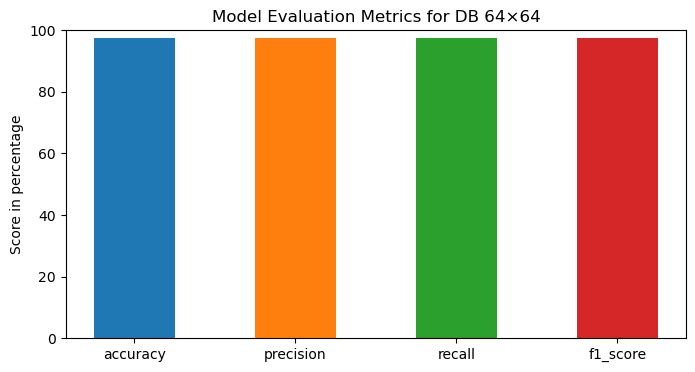

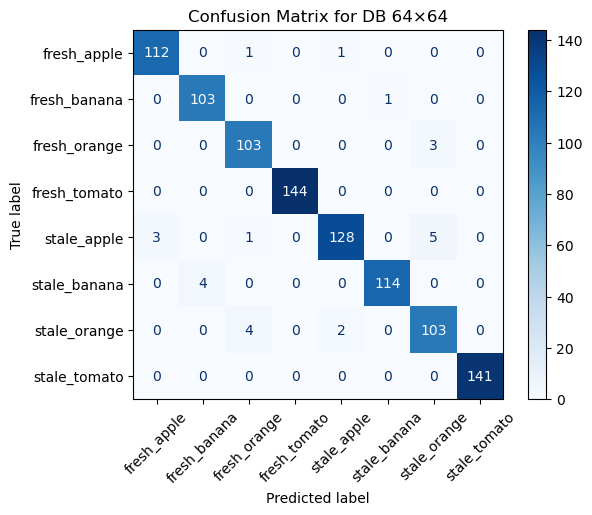

Trying to read previous results for DB 128×128
Were not able to read previous results, computing new ones for DB 128×128
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 95.6133%
  Precision weighted: 96.0274%
  Recall weighted: 95.6133%
  F1 weighted: 95.5856%

Validation Set Evaluation Metrics:
  Accuracy: 91.0542%
  Precision weighted: 91.5914%
  Recall weighted: 91.0542%
  F1 weighted: 91.0114%

Test Set Evaluation Metrics:
  Accuracy: 95.6835%
  Precision: 95.6962%
  Recall: 95.6835%
  F1 score: 95.6838%

Inference time: 0:21:26.323078


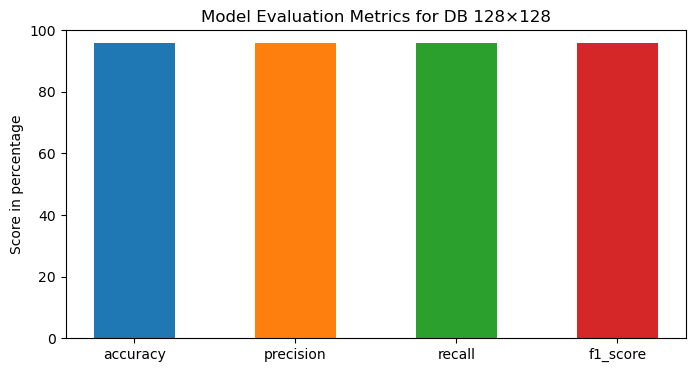

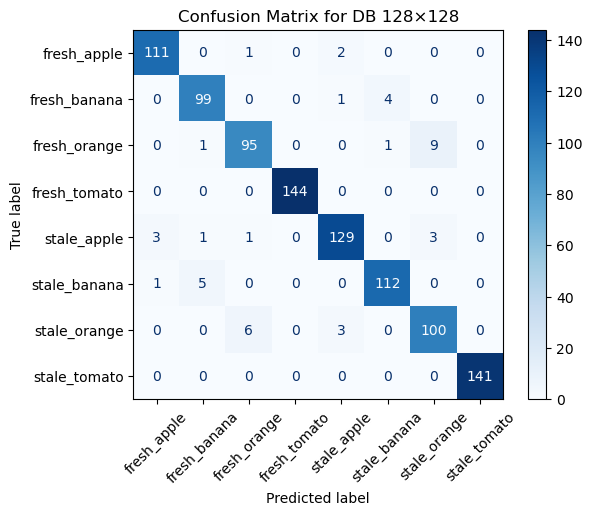

Trying to read previous results for DB 64×64 PCA
Were not able to read previous results, computing new ones for DB 64×64 PCA
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 58.6050%
  Precision weighted: 59.6349%
  Recall weighted: 58.6050%
  F1 weighted: 58.3485%

Validation Set Evaluation Metrics:
  Accuracy: 57.1828%
  Precision weighted: 58.3246%
  Recall weighted: 57.1828%
  F1 weighted: 56.8855%

Test Set Evaluation Metrics:
  Accuracy: 68.0370%
  Precision: 68.7542%
  Recall: 68.0370%
  F1 score: 68.1155%

Inference time: 0:02:12.304072


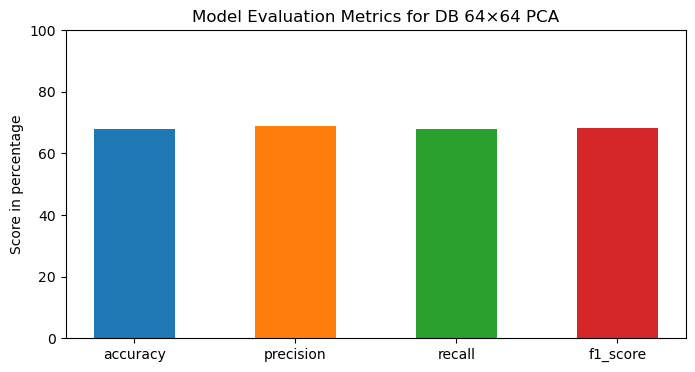

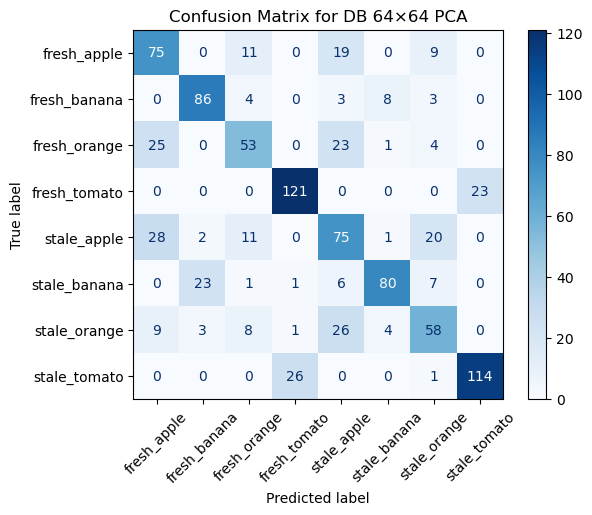

Trying to read previous results for DB 128×128 PCA
Were not able to read previous results, computing new ones for DB 128×128 PCA
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Train Set Evaluation Metrics:
  Accuracy: 47.7092%
  Precision weighted: 48.0676%
  Recall weighted: 47.7092%
  F1 weighted: 46.9282%

Validation Set Evaluation Metrics:
  Accuracy: 45.4403%
  Precision weighted: 45.8678%
  Recall weighted: 45.4403%
  F1 weighted: 44.5982%

Test Set Evaluation Metrics:
  Accuracy: 53.9568%
  Precision: 54.1360%
  Recall: 53.9568%
  F1 score: 53.6706%

Inference time: 0:02:39.712771


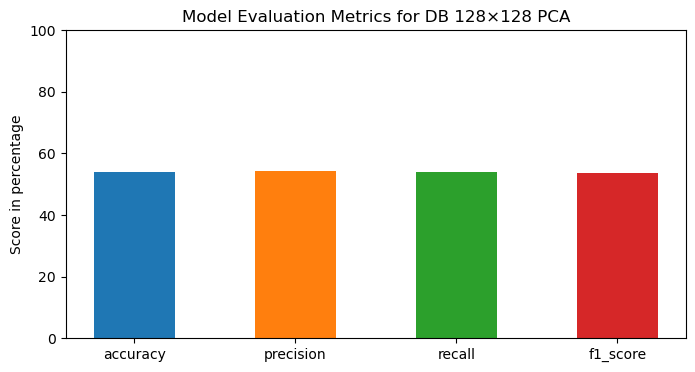

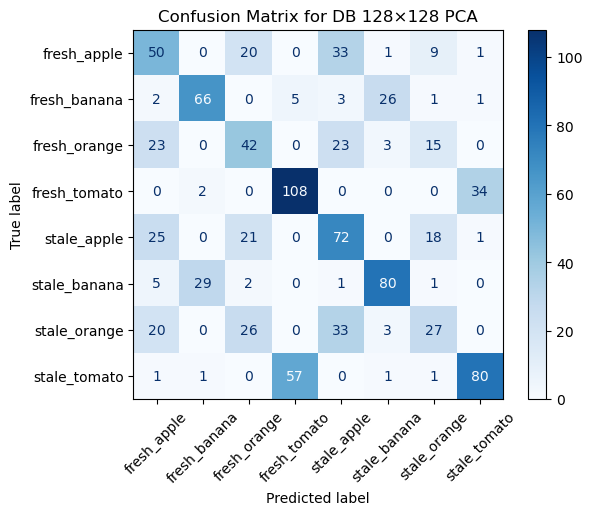

In [12]:
test_scores = {}
for name, path in DB_DICT.items():
    _, _, test_score = main_pipeline(
        name,
        path,
        LABELS_PATH,
        RESULTS_FOLDER,
        RANDOM_STATE,
        ESTIMATOR,
        PARAM_GRID,
        K,
        SCORE_METRICS,
        MAIN_SCORE_METRIC,
    )
    test_scores[name] = test_score

Graficar todas las métricas de prueba para cada una de las bases de datos, para así poder ver gráficamente cuál de las bases de datos nos entregó un mejor resultado.

In [18]:
def plot_grouped_metrics(metrics_dict: dict[str, dict[str, float]]) -> None:
    """
    Plots the evaluation metrics of multiple databases in a grouped bar plot.

    Args:
        metrics_dict (dict[str, dict[str, float]]):
            A dictionary where the keys are database names and the values are dictionaries of metrics.

    Returns:
        None
    """
    # Extract database names and metric names
    db_names = list(metrics_dict.keys())
    metric_names = list(next(iter(metrics_dict.values())).keys())

    # Create data for plotting
    n_dbs = len(db_names)
    n_metrics = len(metric_names)
    width = 0.1  # Width of each bar

    # Define the x positions for the groups of bars
    x = np.arange(n_dbs)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each metric for each database
    for i, metric in enumerate(metric_names):
        values = [
            metrics_dict[db][metric] * 100 for db in db_names
        ]  # Convert to percentage
        ax.bar(x + i * width, values, width, label=metric.capitalize())

    # Customize the plot
    ax.set_xlabel("Databases")
    ax.set_ylabel("Score in Percentage")
    ax.set_title("Comparison of Evaluation Metrics Across Databases")
    ax.set_xticks(x + width * (n_metrics - 1) / 2)
    ax.set_xticklabels(db_names)
    ax.legend(title="Metrics", loc="lower center")
    plt.ylim(75, 100)

    plt.show()

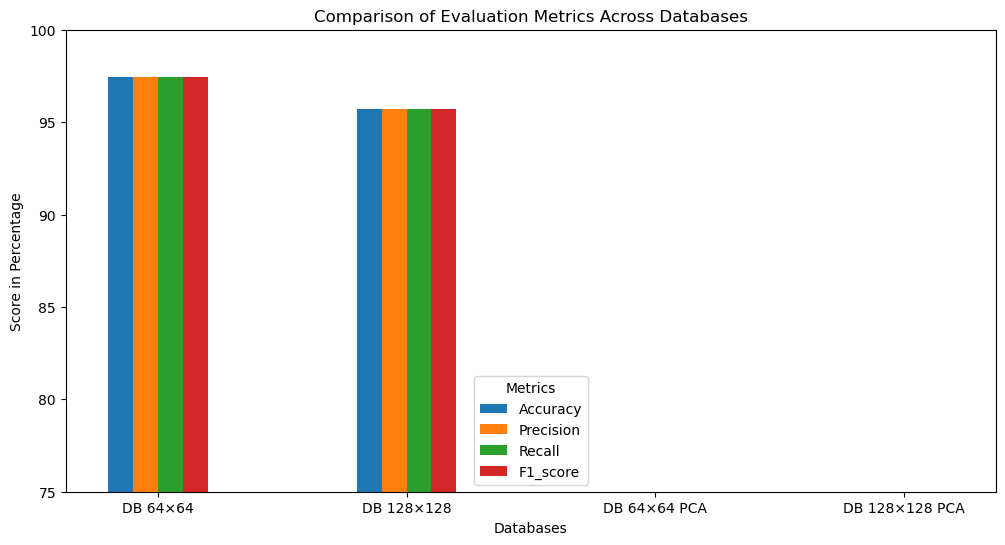

In [19]:
plot_grouped_metrics(test_scores)